# Recurrent Neural Networks - Assignment part 2

#### Authors:
- Izquierdo Alvarez, Mario
- Romero Romero, Martín

### Import Necessary Packages

In [1]:
import os
import sys
utils_path = os.path.join('.','utils')
os.sys.path.append(utils_path)

In [158]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from utils.generateAmazonDataset import readData, transformData
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

from keras.regularizers import l1, l2, l1_l2

# Visualization
import matplotlib.pyplot as plt
from rich import print

### Utility Functions

In [3]:
def plot(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(accuracy) + 1)

    # Create subplots and unpack the axes array immediately
    fig, (ax_accuracy, ax_loss) = plt.subplots(1, 2, figsize=(20, 6))  # figsize=(width, height) in inches

    # Plot training and validation accuracy on the first axis
    ax_accuracy.plot(epochs, accuracy, '-o', label='Training accuracy', color="seagreen", alpha=0.7)
    ax_accuracy.plot(epochs, val_accuracy, '-o', label='Validation accuracy', color="steelblue", alpha=0.7)
    ax_accuracy.set_title('Training and Validation Accuracy')
    ax_accuracy.legend()
    ax_accuracy.set_xlabel('Epoch')
    ax_accuracy.set_ylabel('Accuracy')

    # Plot training and validation loss on the second axis
    ax_loss.plot(epochs, loss, '-o', label='Training loss', color="brown", alpha=0.7)
    ax_loss.plot(epochs, val_loss, '-o', label='Validation loss', color="tan", alpha=0.7)
    ax_loss.set_title('Training and Validation Loss')
    ax_loss.legend()
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')

    # Display the plot
    plt.show()

In [4]:
def save_model_results(file_path, model_name, accuracy):
    """
    This function saves the model's accuracy to a CSV file. It checks if the file exists
    to add a header if necessary and then opens the file in append mode to add
    the model name and accuracy.
    """
    # Check if the file exists to decide on adding the header
    header_needed = not os.path.isfile(file_path)
    
    # Open the file in append mode, which creates the file if it doesn't exist
    with open(file_path, "a") as file:
        # Add a header if the file was just created
        if header_needed:
            file.write("model_name,accuracy\n")
        # Append the model name and accuracy to the file
        file.write(f"{model_name},{accuracy:.3f}\n")

In [5]:
def csv_to_dict(path):
    # Read the CSV file
    data = pd.read_csv(path)
    
    # Ensure 'model_name' and 'accuracy' columns exist
    if 'model_name' not in data.columns or 'accuracy' not in data.columns:
        raise ValueError("The CSV must contain 'model_name' and 'accuracy' columns")
    
    # Convert to dictionary
    models_dict = pd.Series(data.accuracy.values, index=data.model_name).to_dict()
    
    return models_dict

In [168]:
def plot_results_grouped(results_dicts, title='Title', figsize=(20, 10), font_size=12, y_lim = None):
    ''' 
    This function allows plotting several configurations of different methods on the same bar plot.
    A dictionary with each method as the key and with configurations and results dict as the value will be used as input.
    Example: {'Method_1': {'config_1':(1, 0.5), ...}, 'Method_2':{...}...}. Each Method will be plotted with a different color.
    '''
    
    methods = list(results_dicts.keys())
    colors = ['seagreen', 'tan', 'lightsteelblue', 'mediumpurple', 'dimgrey', 'mediumaquamarine']  # Colors for each method
    color_map = dict(zip(methods, colors[:len(methods)]))
    
    fig, ax = plt.subplots(figsize=figsize)
    width = 0.35  # Bar width
    
    total_configs = sum([len(results_dicts[method]) for method in methods])  # Total configurations
    x = np.linspace(0, total_configs * width * 1.5, total_configs)  # Spacing
    
    max_value = 0  # Initialize max value for accuracy
    
    current_position = 0
    for method in methods:
        labels = list(results_dicts[method].keys())
        results = list(results_dicts[method].values())
        
        # Update max_value if current results contain a new max
        max_value = max(max_value, max(results))
        
        # Creating the bars for each method
        rects = ax.bar(x[current_position:current_position+len(labels)], results, width,
                       label=method, color=color_map[method], alpha=0.6)
        ax.bar_label(rects, padding=3, fontsize=font_size)
        
        current_position += len(labels)  # Update the position for the next group of bars
    
    ax.set_ylabel('Accuracy', fontsize=font_size)
    ax.set_title(title, fontsize=font_size + 2)
    
    all_labels = [config for method in methods for config in results_dicts[method]]
    ax.set_xticks(x[:len(all_labels)])
    ax.set_xticklabels(all_labels, rotation=45, ha="right", fontsize=font_size)
    
    ax.legend(title="Methods", title_fontsize=font_size, fontsize=font_size)
    
    ax.tick_params(axis='y', labelsize=font_size)
    if y_lim:
        plt.ylim(*y_lim)
    else:
        plt.ylim(0, max_value + 0.1)  # Adjust y_lim to make sure min_value is visible
    
    # Draw a horizontal line at the maximum accuracy value
    plt.axhline(y=max_value, color='brown', alpha=0.6, linestyle='--', label=f'Max Accuracy: {max_value}')
    plt.legend(title="Methods", title_fontsize=font_size, fontsize=font_size)
    
    fig.tight_layout()
    plt.show()

In [161]:
def filter_models_by_keywords(results_dict, keywords):
    """
    Filters the given dictionary of model results based on a list of keywords.
    Each keyword generates a new dictionary containing key-value pairs from the
    results_dict where the key includes the keyword. Each pair is only included
    in the first matching dictionary based on the order of the keywords list.
    
    :param results_dict: Dictionary with model names as keys and numerical results as values.
    :param keywords: List of keywords to filter the models by.
    :return: List of dictionaries, each corresponding to one of the keywords.
    """
    # Initialize a list to store the resulting dictionaries
    filtered_results = {}
    # Initialize a set to keep track of models that have already been added
    added_models = set()
    
    # Iterate over each keyword
    for keyword in keywords:
        # Create a new dictionary for the current keyword
        current_dict = {}
        # Iterate over each item in the original dictionary
        for model_name, result in results_dict.items():
            # Check if the model name contains the current keyword and hasn't been added yet
            if keyword in model_name and model_name not in added_models:
                # Add the model-result pair to the current dictionary
                current_dict[model_name] = result
                # Mark the model as added
                added_models.add(model_name)
        # Add the current dictionary to the list of filtered results
        filtered_results[keyword] = current_dict
    
    return filtered_results

### Define some global variables

In [7]:
val_results_path = "val_results.csv"
test_results_path = "test_results.csv"

In [8]:
val_size = 0.2

maxFeatures = 2000 # Vocabulary size
batchSize = 128

### Prepare data

In [65]:
x_train, y_train, seqLength = readData("data/amazon/train_small.txt")
x_test, y_test, tmp = readData("data/amazon/test_small.txt")
  
x_train_int, y_train, x_val_int, y_val, x_test_int, y_test = transformData(x_train, y_train, x_test, y_test, 
maxFeatures, seqLength, val_size = val_size)

print(f"[bold purple]Training[/bold purple]   - X: {x_train_int.shape}\tY: {y_train.shape}")
print(f"[bold purple]Validation[/bold purple] - X: {x_val_int.shape}\tY: {y_val.shape}")
print(f"[bold purple]Test[/bold purple]       - X: {x_test_int.shape}\tY: {y_test.shape}")

Training   - X: (20000, 166)    Y: (20000,)

Validation - X: (5000, 166)     Y: (5000,)

Test       - X: (25000, 166)    Y: (25000,)

## **First SimpleRNN model**
### Bulding the model

In [10]:
model_name = "SimpleRNN_32_16"

In [11]:
inputs = tf.keras.Input(shape=(seqLength,))
x = layers.Embedding(maxFeatures, 200, mask_zero=True)(inputs)
x = layers.SimpleRNN(units=32, activation='tanh', return_sequences=True)(x)
x = layers.SimpleRNN(units=16, activation='tanh')(x)

outputs = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs, name="sentiment_analysis")

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sentiment_analysis"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 166)       │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ embedding           │ (None, 166, 200)  │ 400,000 │ input_layer[0][0]    │
│ (Embedding)         │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ not_equal           │ (None, 166)       │       0 │ input_layer[0][0]    │
│ (NotEqual)          │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ simple_rnn          │ (None, 166, 32)   │   7,456 │ embedding[0][0],     │
│ (SimpleRNN)         │                   │         │ not_equal[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ simple_rnn_1        │ (None, 16)        │     784 │ simple_rnn[0][0],    │
│ (SimpleRNN)         │                   │         │ not_equal[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense (Dense)       │ (None, 1)         │      17 │ simple_rnn_1[0][0]   │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 408,257 (1.56 MB)

 Trainable params: 408,257 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [12]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=20,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    x_train_int,
    y_train,
    epochs=100, 
    batch_size=batchSize, 
    validation_data=(x_val_int,y_val), 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5932 - loss: 0.6619 - val_accuracy: 0.7219 - val_loss: 0.5583
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7566 - loss: 0.5078 - val_accuracy: 0.7537 - val_loss: 0.5366
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7411 - loss: 0.5288 - val_accuracy: 0.7422 - val_loss: 0.5462
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7823 - loss: 0.4819 - val_accuracy: 0.7730 - val_loss: 0.4821
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8058 - loss: 0.4308 - val_accuracy: 0.7621 - val_loss: 0.4959
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8489 - loss: 0.3728 - val_accuracy: 0.7529 - val_loss: 0.5573
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8516 - loss: 0.3680 - val_accuracy: 0.7385 - val_loss: 0.5644
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8540 - loss: 0.3559 - 

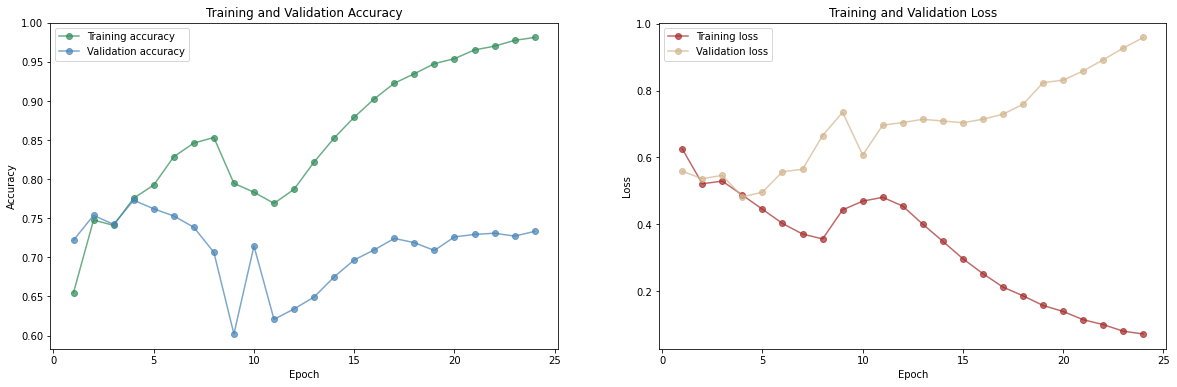

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8233 - loss: 0.4044
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7687 - loss: 0.4885
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7615 - loss: 0.4950


Training Accuracy: 0.8209999799728394

Validation Accuracy: 0.7710987329483032

In [13]:
plot(history)
train_acc = model.evaluate(x_train_int, y_train)[-1] 
val_acc = model.evaluate(x_val_int, y_val)[-1]
test_acc = model.evaluate(x_test_int, y_test)[-1]
print(f"Training Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")

save_model_results(val_results_path, model_name, val_acc)
save_model_results(test_results_path, model_name, test_acc)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**
Good results for the simplicity of the SimpleRNN. Training was not very stable and a considerable amount of overfitting is noticeable. More complex models are going to be tested.
</div>

## **Complex SimpleRNN model**
### Bulding the model

In [17]:
model_name = "complex_SimpleRNN"

In [18]:
inputs = tf.keras.Input(shape=(seqLength,))
x = layers.Embedding(maxFeatures, 200, mask_zero=True)(inputs)
x = layers.SimpleRNN(units=64, return_sequences=True)(x)
x = layers.SimpleRNN(units=128, return_sequences=True)(x)
x = layers.SimpleRNN(units=128)(x)

x = layers.Dense(64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs, name="sentiment_analysis")

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sentiment_analysis"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 166)       │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ embedding_2         │ (None, 166, 200)  │ 400,000 │ input_layer_2[0][0]  │
│ (Embedding)         │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ not_equal_2         │ (None, 166)       │       0 │ input_layer_2[0][0]  │
│ (NotEqual)          │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ simple_rnn_5        │ (None, 166, 64)   │  16,960 │ embedding_2[0][0],   │
│ (SimpleRNN)         │                   │         │ not_equal_2[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ simple_rnn_6        │ (None, 166, 128)  │  24,704 │ simple_rnn_5[0][0],  │
│ (SimpleRNN)         │                   │         │ not_equal_2[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ simple_rnn_7        │ (None, 128)       │  32,896 │ simple_rnn_6[0][0],  │
│ (SimpleRNN)         │                   │         │ not_equal_2[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │   8,256 │ simple_rnn_7[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │      65 │ dense_3[0][0]        │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 482,881 (1.84 MB)

 Trainable params: 482,881 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [19]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    x_train_int,
    y_train,
    epochs=100, 
    batch_size=batchSize, 
    validation_data=(x_val_int,y_val), 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.5628 - loss: 0.6937 - val_accuracy: 0.4820 - val_loss: 0.7001
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6247 - loss: 0.6380 - val_accuracy: 0.5430 - val_loss: 0.6883
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6532 - loss: 0.6111 - val_accuracy: 0.8107 - val_loss: 0.4529
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8108 - loss: 0.4348 - val_accuracy: 0.7494 - val_loss: 0.5152
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8197 - loss: 0.4082 - val_accuracy: 0.7895 - val_loss: 0.4402
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9148 - loss: 0.2191 - val_accuracy: 0.6990 - val_loss: 0.6773
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7997 - loss: 0.4254 - val_accuracy: 0.6936 - val_loss: 0.6206
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8659 - loss: 0.3194 - 

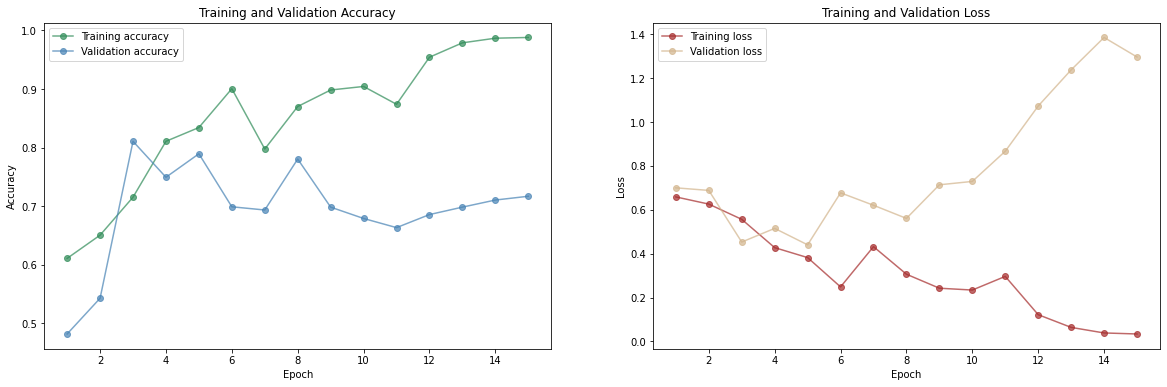

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8929 - loss: 0.2660
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7876 - loss: 0.4387
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7867 - loss: 0.4571


Training Accuracy: 0.8894500136375427

Validation Accuracy: 0.7856289744377136

In [20]:
plot(history)
train_acc = model.evaluate(x_train_int, y_train)[-1] 
val_acc = model.evaluate(x_val_int, y_val)[-1]
test_acc = model.evaluate(x_test_int, y_test)[-1]
print(f"Training Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")

save_model_results(val_results_path, model_name, val_acc)
save_model_results(test_results_path, model_name, test_acc)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**
Similar outcomes. Although the results of the selected model show **slightly better** results than the previous case, it is not a significant difference. In addition, the evolution of the metrics presents similar conditions, obtaining very good results for the training set, but with a clear **overfitting**. We will try to reduce this overfitting by means of different regularization techniques.
</div>

## **Complex SimpleRNN - DropOut**
### Bulding the model

In [31]:
model_name = "complex_SimpleRNN_dropOut"

In [34]:
inputs = tf.keras.Input(shape=(seqLength,))
x = layers.Embedding(maxFeatures, 200, mask_zero=True)(inputs)
x = layers.SimpleRNN(units=64, return_sequences=True)(x)
x = layers.SimpleRNN(units=128, return_sequences=True,
                     dropout=0.2, recurrent_dropout=0.5)(x)

x = layers.SimpleRNN(units=128, dropout= 0.2)(x)

x = layers.Dense(64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs, name="sentiment_analysis")

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sentiment_analysis"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 166)       │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ embedding_8         │ (None, 166, 200)  │ 400,000 │ input_layer_8[0][0]  │
│ (Embedding)         │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ not_equal_8         │ (None, 166)       │       0 │ input_layer_8[0][0]  │
│ (NotEqual)          │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ simple_rnn_23       │ (None, 166, 64)   │  16,960 │ embedding_8[0][0],   │
│ (SimpleRNN)         │                   │         │ not_equal_8[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ simple_rnn_24       │ (None, 166, 128)  │  24,704 │ simple_rnn_23[0][0], │
│ (SimpleRNN)         │                   │         │ not_equal_8[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ simple_rnn_25       │ (None, 128)       │  32,896 │ simple_rnn_24[0][0], │
│ (SimpleRNN)         │                   │         │ not_equal_8[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │   8,256 │ simple_rnn_25[0][0]  │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_16 (Dense)    │ (None, 1)         │      65 │ dense_15[0][0]       │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 482,881 (1.84 MB)

 Trainable params: 482,881 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [35]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=30,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    x_train_int,
    y_train,
    epochs=100, 
    batch_size=batchSize, 
    validation_data=(x_val_int,y_val), 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.5095 - loss: 0.7143 - val_accuracy: 0.5857 - val_loss: 0.6670
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5982 - loss: 0.6590 - val_accuracy: 0.7195 - val_loss: 0.5559
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7408 - loss: 0.5277 - val_accuracy: 0.8219 - val_loss: 0.4189
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8435 - loss: 0.3759 - val_accuracy: 0.7951 - val_loss: 0.4562
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8952 - loss: 0.2714 - val_accuracy: 0.8572 - val_loss: 0.4155
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9313 - loss: 0.1888 - val_accuracy: 0.8410 - val_loss: 0.4989
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9523 - loss: 0.1252 - val_accuracy: 0.8314 - val_loss: 0.5527
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9613 - loss: 0.1063 -

### Evaluation

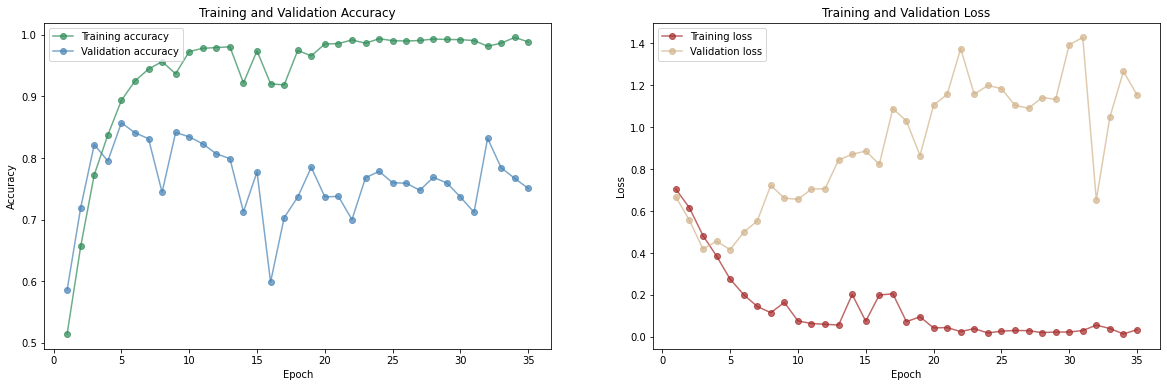

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9315 - loss: 0.1830
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8550 - loss: 0.4319
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8425 - loss: 0.4471


Training Accuracy: 0.9332500100135803

Validation Accuracy: 0.8546974658966064

In [37]:
plot(history)
train_acc = model.evaluate(x_train_int, y_train)[-1] 
val_acc = model.evaluate(x_val_int, y_val)[-1]
test_acc = model.evaluate(x_test_int, y_test)[-1]
print(f"Training Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")

save_model_results(val_results_path, model_name, val_acc)
save_model_results(test_results_path, model_name, test_acc)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**
After several experiments, it has been found that the use of high probability **dropOut (0.5)**, in general tends to generate **poor** performance, resulting in models that are limited in their learning capacity and **stop improving** when reaching an accuracy of 50%. However, we have been able to verify that the model **responds adequately** to the use of **recurrent dropout**. In this case we present the results of applying a **low** probability dropout and a **recurrent dropout** of **0.5**. It can be seen that the results are **better** than those obtained previously, slightly alleviating the overfitting. However, it can be seen in the evolution of the metrics as this overfitting is still very present. We will now test the use of more recurrent dropout to try to further reduce this overfitting.
</div>

## **Complex SimpleRNN - High recurrent DropOut**
### Bulding the model

In [15]:
model_name = "complex_SimpleRNN_high_rec_dpOut"

In [16]:
inputs = tf.keras.Input(shape=(seqLength,))
x = layers.Embedding(maxFeatures, 200, mask_zero=True)(inputs)
x = layers.SimpleRNN(units=64, return_sequences=True,
                     dropout=0.15, recurrent_dropout=0.5)(x)
x = layers.SimpleRNN(units=128, return_sequences=True,
                     dropout=0.3, recurrent_dropout=0.5)(x)

x = layers.SimpleRNN(units=128, dropout= 0.2)(x)

x = layers.Dense(64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs, name="sentiment_analysis")

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sentiment_analysis"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 166)       │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ embedding_1         │ (None, 166, 200)  │ 400,000 │ input_layer_1[0][0]  │
│ (Embedding)         │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ not_equal_1         │ (None, 166)       │       0 │ input_layer_1[0][0]  │
│ (NotEqual)          │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ simple_rnn_3        │ (None, 166, 64)   │  16,960 │ embedding_1[0][0],   │
│ (SimpleRNN)         │                   │         │ not_equal_1[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ simple_rnn_4        │ (None, 166, 128)  │  24,704 │ simple_rnn_3[0][0],  │
│ (SimpleRNN)         │                   │         │ not_equal_1[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ simple_rnn_5        │ (None, 128)       │  32,896 │ simple_rnn_4[0][0],  │
│ (SimpleRNN)         │                   │         │ not_equal_1[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │   8,256 │ simple_rnn_5[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      65 │ dense_2[0][0]        │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 482,881 (1.84 MB)

 Trainable params: 482,881 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [17]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=30,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    x_train_int,
    y_train,
    epochs=100, 
    batch_size=batchSize, 
    validation_data=(x_val_int,y_val), 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.5083 - loss: 0.7172 - val_accuracy: 0.5180 - val_loss: 0.6960
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5115 - loss: 0.6977 - val_accuracy: 0.5396 - val_loss: 0.6905
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5230 - loss: 0.6926 - val_accuracy: 0.6963 - val_loss: 0.6027
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5867 - loss: 0.6706 - val_accuracy: 0.5564 - val_loss: 0.6756
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6347 - loss: 0.6392 - val_accuracy: 0.7385 - val_loss: 0.5656
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7408 - loss: 0.5613 - val_accuracy: 0.6404 - val_loss: 0.6162
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6375 - loss: 0.6270 - val_accuracy: 0.6521 - val_loss: 0.6085
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6579 - loss: 0.6053 -

### Evaluation

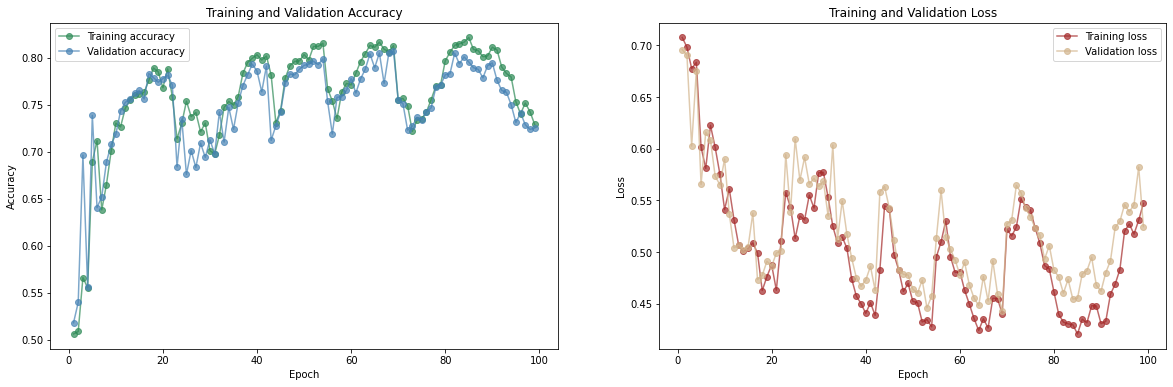

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8345 - loss: 0.3958
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8067 - loss: 0.4459
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8033 - loss: 0.4507


Training Accuracy: 0.8345500230789185

Validation Accuracy: 0.8037420511245728

In [19]:
plot(history)
train_acc = model.evaluate(x_train_int, y_train)[-1] 
val_acc = model.evaluate(x_val_int, y_val)[-1]
test_acc = model.evaluate(x_test_int, y_test)[-1]
print(f"Training Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")

save_model_results(val_results_path, model_name, val_acc)
save_model_results(test_results_path, model_name, test_acc)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**
After testing various configurations and dropOut probabilities, we have managed to reduce the overfitting, as shown in the graphs above. However, this has **sacrificed** to some extent the **learning capacity** of the training, obtaining in this case results in train and validation **slightly worse** than those obtained in the previous training, using a more moderate dropOut. Therefore, we will explore the use of other regularization techniques, such as **L1 and L2** regularization, also incorporating batchNormalization, which can help in the stability of the training, seeking to reduce the overfitting without sacrificing the expressiveness of the model.

</div>

## **Complex SimpleRNN - L2 Regularization + Batch normalization**
### Bulding the model

In [22]:
model_name = "complex_SimpleRNN_L2_bn"

In [27]:
inputs = tf.keras.Input(shape=(seqLength,))
x = layers.Embedding(maxFeatures, 200, mask_zero=True)(inputs)
x = layers.BatchNormalization()(x)  # Batch normalization after embedding

x = layers.SimpleRNN(units=64, return_sequences=True,
                     kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.01))(x)
x = layers.SimpleRNN(units=128, return_sequences=True,
                     kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.01))(x)
x = layers.SimpleRNN(units=128, 
                     kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))(x)

x = layers.BatchNormalization()(x)  # Batch normalization after all RNN layers are done
x = layers.Dense(64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs, name="sentiment_analysis")
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sentiment_analysis"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 166)       │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ embedding_4         │ (None, 166, 200)  │ 400,000 │ input_layer_4[0][0]  │
│ (Embedding)         │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ not_equal_4         │ (None, 166)       │       0 │ input_layer_4[0][0]  │
│ (NotEqual)          │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 166, 200)  │     800 │ embedding_4[0][0],   │
│ (BatchNormalizatio… │                   │         │ not_equal_4[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ simple_rnn_12       │ (None, 166, 64)   │  16,960 │ batch_normalization… │
│ (SimpleRNN)         │                   │         │ not_equal_4[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ simple_rnn_13       │ (None, 166, 128)  │  24,704 │ simple_rnn_12[0][0], │
│ (SimpleRNN)         │                   │         │ not_equal_4[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ simple_rnn_14       │ (None, 128)       │  32,896 │ simple_rnn_13[0][0], │
│ (SimpleRNN)         │                   │         │ not_equal_4[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 128)       │     512 │ simple_rnn_14[0][0]  │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │   8,256 │ batch_normalization… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │      65 │ dense_8[0][0]        │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 484,193 (1.85 MB)

 Trainable params: 483,537 (1.84 MB)

 Non-trainable params: 656 (2.56 KB)

### Training

In [28]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=30,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    x_train_int,
    y_train,
    epochs=100, 
    batch_size=batchSize, 
    validation_data=(x_val_int,y_val), 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.5984 - loss: 4.4177 - val_accuracy: 0.5398 - val_loss: 2.4841
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7392 - loss: 1.6748 - val_accuracy: 0.5125 - val_loss: 1.3898
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7037 - loss: 1.1433 - val_accuracy: 0.6883 - val_loss: 1.0413
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7111 - loss: 0.9869 - val_accuracy: 0.7055 - val_loss: 0.9495
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7580 - loss: 0.8579 - val_accuracy: 0.7018 - val_loss: 0.8861
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7639 - loss: 0.7996 - val_accuracy: 0.7197 - val_loss: 0.8693
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7466 - loss: 0.8161 - val_accuracy: 0.6592 - val_loss: 0.9650
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7206 - loss: 0.9002 - 

### Evaluation

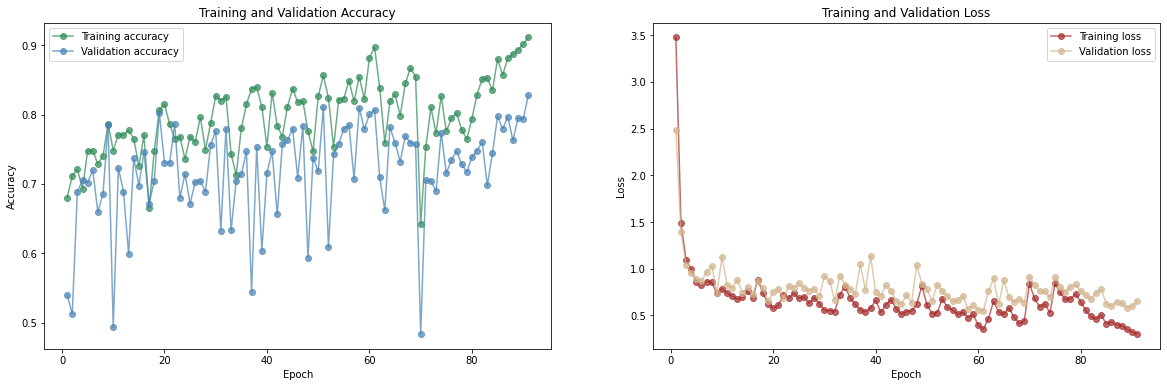

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9203 - loss: 0.3204
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8008 - loss: 0.5681
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7874 - loss: 0.5868


Training Accuracy: 0.9168000221252441

Validation Accuracy: 0.8059315085411072

In [30]:
plot(history)
train_acc = model.evaluate(x_train_int, y_train)[-1] 
val_acc = model.evaluate(x_val_int, y_val)[-1]
test_acc = model.evaluate(x_test_int, y_test)[-1]
print(f"Training Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")

save_model_results(val_results_path, model_name, val_acc)
save_model_results(test_results_path, model_name, test_acc)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**

After testing regularization techniques, the use of **L2** and **BatchNormalization** has provided a more controlled and **stable** training. However, despite getting a more stable training, the model accuracy has not significantly improved with respect to the last model. After testing several SimpleRNN architectures and regularization configurations, it seems like we cannot further improve the results. This could be due to some **important problems related with RNN**, such us the **vanishing** gradients. This could cause **critical** words to lose **influence** in the final classification, especially for **long sequences**. To solve this problem, we are going to use other architectures such us **LSTMs**, that enhances the Long short-term memory, **partially solving** this issue and allowing longer sequences.

</div>

## **Complex LSTM - Dropout**
### Bulding the model

In [48]:
model_name = "complex_LSTM_dropout"

In [49]:
inputs = tf.keras.Input(shape=(seqLength,))
x = layers.Embedding(maxFeatures, 200, mask_zero=True)(inputs)
x = layers.LSTM(units=64, return_sequences=True)(x)
x = layers.LSTM(units=128, return_sequences=True,
                     dropout=0.2, recurrent_dropout=0.5)(x)

x = layers.LSTM(units=128, dropout= 0.2)(x)

x = layers.Dense(64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs, name="sentiment_analysis")

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sentiment_analysis"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 166)       │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ embedding_11        │ (None, 166, 200)  │ 400,000 │ input_layer_11[0][0] │
│ (Embedding)         │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ not_equal_11        │ (None, 166)       │       0 │ input_layer_11[0][0] │
│ (NotEqual)          │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lstm (LSTM)         │ (None, 166, 64)   │  67,840 │ embedding_11[0][0],  │
│                     │                   │         │ not_equal_11[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lstm_1 (LSTM)       │ (None, 166, 128)  │  98,816 │ lstm[0][0],          │
│                     │                   │         │ not_equal_11[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lstm_2 (LSTM)       │ (None, 128)       │ 131,584 │ lstm_1[0][0],        │
│                     │                   │         │ not_equal_11[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_30 (Dense)    │ (None, 64)        │   8,256 │ lstm_2[0][0]         │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_31 (Dense)    │ (None, 1)         │      65 │ dense_30[0][0]       │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 706,561 (2.70 MB)

 Trainable params: 706,561 (2.70 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [50]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=30,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    x_train_int,
    y_train,
    epochs=100, 
    batch_size=batchSize, 
    validation_data=(x_val_int,y_val), 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 213ms/step - accuracy: 0.6996 - loss: 0.5501 - val_accuracy: 0.8410 - val_loss: 0.3656
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.8408 - loss: 0.3721 - val_accuracy: 0.8607 - val_loss: 0.3313
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 213ms/step - accuracy: 0.8780 - loss: 0.2988 - val_accuracy: 0.8660 - val_loss: 0.3159
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 211ms/step - accuracy: 0.8975 - loss: 0.2629 - val_accuracy: 0.8744 - val_loss: 0.3104
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 211ms/step - accuracy: 0.9029 - loss: 0.2429 - val_accuracy: 0.8750 - val_loss: 0.3109
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.9136 - loss: 0.2266 - val_accuracy: 0.8818 - val_loss: 0.3171
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 213ms/step - accuracy: 0.9279 - loss: 0.1925 - val_accuracy: 0.8793 - val_loss: 0.3557
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.9327 -

### Evaluation

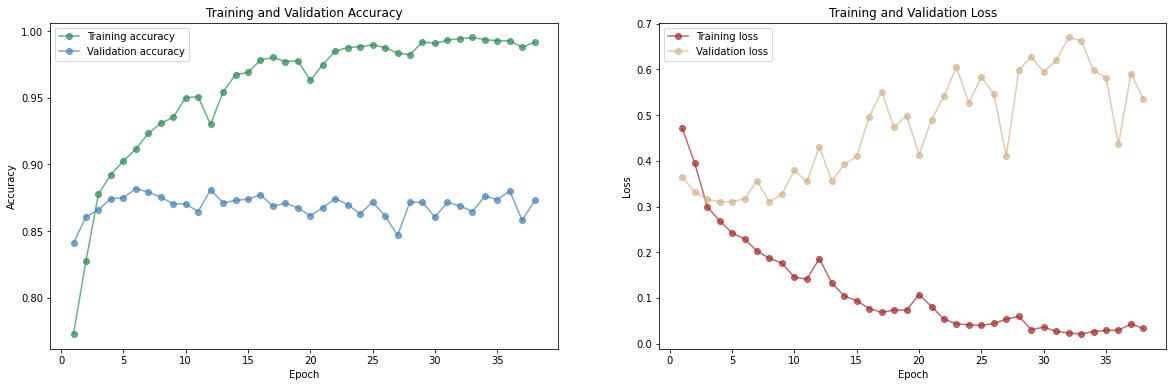

625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.9445 - loss: 0.1693
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8683 - loss: 0.3181
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 47ms/step - accuracy: 0.8678 - loss: 0.3179


Training Accuracy: 0.9430500268936157

Validation Accuracy: 0.8730095624923706

In [56]:
plot(history)
train_acc = model.evaluate(x_train_int, y_train)[-1] 
val_acc = model.evaluate(x_val_int, y_val)[-1]
test_acc = model.evaluate(x_test_int, y_test)[-1]
print(f"Training Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")

save_model_results(val_results_path, model_name, val_acc)
save_model_results(test_results_path, model_name, test_acc)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**
In this model, we have changed the type of recurrent layer, and now we use **LSTM layers**. The result obtained by this model in terms of accuracy has improved significantly with respect to the previous models. However, there is still some **overfitting** in the model despite the use of **recurrent dropouts** to try to avoid it. In the following model we will try to avoid this overfitting by using **other regularization** techniques.

</div>

## **Complex LSTM - L2 Regularization + Batch normalization**
### Bulding the model

In [10]:
model_name = "complex_LSTM_L2_bn"

In [11]:
inputs = tf.keras.Input(shape=(seqLength,))
x = layers.Embedding(maxFeatures, 200, mask_zero=True)(inputs)
x = layers.BatchNormalization()(x)

x = layers.LSTM(units=64, return_sequences=True,
                     kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))(x)
x = layers.LSTM(units=128, return_sequences=True,
                     kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))(x)
x = layers.LSTM(units=128, 
                     kernel_regularizer=l2(0.1), recurrent_regularizer=l2(0.1))(x)

x = layers.BatchNormalization()(x)
x = layers.Dense(64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs, name="sentiment_analysis")
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sentiment_analysis"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 166)       │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ embedding           │ (None, 166, 200)  │ 400,000 │ input_layer[0][0]    │
│ (Embedding)         │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ not_equal           │ (None, 166)       │       0 │ input_layer[0][0]    │
│ (NotEqual)          │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalization │ (None, 166, 200)  │     800 │ embedding[0][0],     │
│ (BatchNormalizatio… │                   │         │ not_equal[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lstm (LSTM)         │ (None, 166, 64)   │  67,840 │ batch_normalization… │
│                     │                   │         │ not_equal[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lstm_1 (LSTM)       │ (None, 166, 128)  │  98,816 │ lstm[0][0],          │
│                     │                   │         │ not_equal[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lstm_2 (LSTM)       │ (None, 128)       │ 131,584 │ lstm_1[0][0],        │
│                     │                   │         │ not_equal[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 128)       │     512 │ lstm_2[0][0]         │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense (Dense)       │ (None, 64)        │   8,256 │ batch_normalization… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      65 │ dense[0][0]          │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 707,873 (2.70 MB)

 Trainable params: 707,217 (2.70 MB)

 Non-trainable params: 656 (2.56 KB)

### Training

In [12]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=30,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    x_train_int,
    y_train,
    epochs=100, 
    batch_size=batchSize, 
    validation_data=(x_val_int,y_val), 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 199ms/step - accuracy: 0.7150 - loss: 17.4840 - val_accuracy: 0.5150 - val_loss: 1.0939
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 198ms/step - accuracy: 0.8697 - loss: 0.6027 - val_accuracy: 0.6369 - val_loss: 0.7353
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step - accuracy: 0.8870 - loss: 0.3672 - val_accuracy: 0.8664 - val_loss: 0.4437
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - accuracy: 0.9022 - loss: 0.3065 - val_accuracy: 0.8795 - val_loss: 0.3599
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - accuracy: 0.9197 - loss: 0.2577 - val_accuracy: 0.8711 - val_loss: 0.3611
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - accuracy: 0.9299 - loss: 0.2323 - val_accuracy: 0.8721 - val_loss: 0.3769
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 198ms/step - accuracy: 0.9372 - loss: 0.2126 - val_accuracy: 0.8695 - val_loss: 0.4266
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - accuracy: 0.9406 

### Evaluation

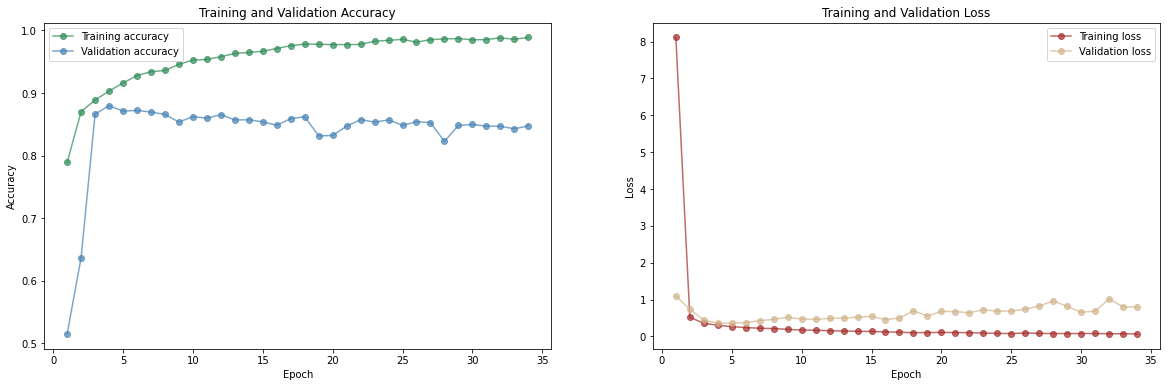

625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.9293 - loss: 0.2901
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8751 - loss: 0.3710
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.8737 - loss: 0.3659


Training Accuracy: 0.9309499859809875

Validation Accuracy: 0.8795780539512634

In [14]:
plot(history)
train_acc = model.evaluate(x_train_int, y_train)[-1] 
val_acc = model.evaluate(x_val_int, y_val)[-1]
test_acc = model.evaluate(x_test_int, y_test)[-1]
print(f"Training Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")

save_model_results(val_results_path, model_name, val_acc)
save_model_results(test_results_path, model_name, test_acc)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**
After using **L2** regularization and **BatchNormalization** we have been able to significantly reduce the overfitting of the model, obtaining once again a much more **stable training**. In addition, the **accuracy** of the model has **increased** with respect to the previous model, so the application of these regularization techniques has managed to reduce the overfitting and apparently improve the performance of the model.

On the other hand, given that the training still exhibits a slight overfitting, we are going to test **L1_L1 regularization**, a stronger regularization technique, trying to further improve the validation accuracy.

</div>

## **Complex LSTM - L1-L2 Regularization + Batch normalization**
### Bulding the model

In [21]:
model_name = "complex_LSTM_L1_L2_bn"

In [22]:
inputs = tf.keras.Input(shape=(seqLength,))
x = layers.Embedding(maxFeatures, 200, mask_zero=True)(inputs)
x = layers.BatchNormalization()(x)

x = layers.LSTM(units=64, return_sequences=True,
                     kernel_regularizer=l1_l2(0.01), recurrent_regularizer=l1_l2(0.01))(x)
x = layers.LSTM(units=128, return_sequences=True,
                     kernel_regularizer=l1_l2(0.01), recurrent_regularizer=l1_l2(0.01))(x)
x = layers.LSTM(units=128, 
                     kernel_regularizer=l1_l2(0.01), recurrent_regularizer=l1_l2(0.01))(x)

x = layers.BatchNormalization()(x)
x = layers.Dense(64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs, name="sentiment_analysis")
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sentiment_analysis"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 166)       │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ embedding_2         │ (None, 166, 200)  │ 400,000 │ input_layer_2[0][0]  │
│ (Embedding)         │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ not_equal_2         │ (None, 166)       │       0 │ input_layer_2[0][0]  │
│ (NotEqual)          │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 166, 200)  │     800 │ embedding_2[0][0],   │
│ (BatchNormalizatio… │                   │         │ not_equal_2[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lstm_6 (LSTM)       │ (None, 166, 64)   │  67,840 │ batch_normalization… │
│                     │                   │         │ not_equal_2[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lstm_7 (LSTM)       │ (None, 166, 128)  │  98,816 │ lstm_6[0][0],        │
│                     │                   │         │ not_equal_2[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lstm_8 (LSTM)       │ (None, 128)       │ 131,584 │ lstm_7[0][0],        │
│                     │                   │         │ not_equal_2[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 128)       │     512 │ lstm_8[0][0]         │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │   8,256 │ batch_normalization… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │      65 │ dense_4[0][0]        │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 707,873 (2.70 MB)

 Trainable params: 707,217 (2.70 MB)

 Non-trainable params: 656 (2.56 KB)

### Training

In [23]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=30,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    x_train_int,
    y_train,
    epochs=100, 
    batch_size=batchSize, 
    validation_data=(x_val_int,y_val), 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 201ms/step - accuracy: 0.6820 - loss: 65.6935 - val_accuracy: 0.5166 - val_loss: 1.2518
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 198ms/step - accuracy: 0.7742 - loss: 0.9507 - val_accuracy: 0.7178 - val_loss: 1.0896
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step - accuracy: 0.8283 - loss: 0.8005 - val_accuracy: 0.6539 - val_loss: 0.9937
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - accuracy: 0.8795 - loss: 0.7219 - val_accuracy: 0.8025 - val_loss: 0.8751
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - accuracy: 0.8786 - loss: 0.7192 - val_accuracy: 0.8602 - val_loss: 0.7542
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - accuracy: 0.8871 - loss: 0.6960 - val_accuracy: 0.6893 - val_loss: 1.1661
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step - accuracy: 0.8960 - loss: 0.6740 - val_accuracy: 0.7799 - val_loss: 1.0625
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - accuracy: 0.8962 

### Evaluation

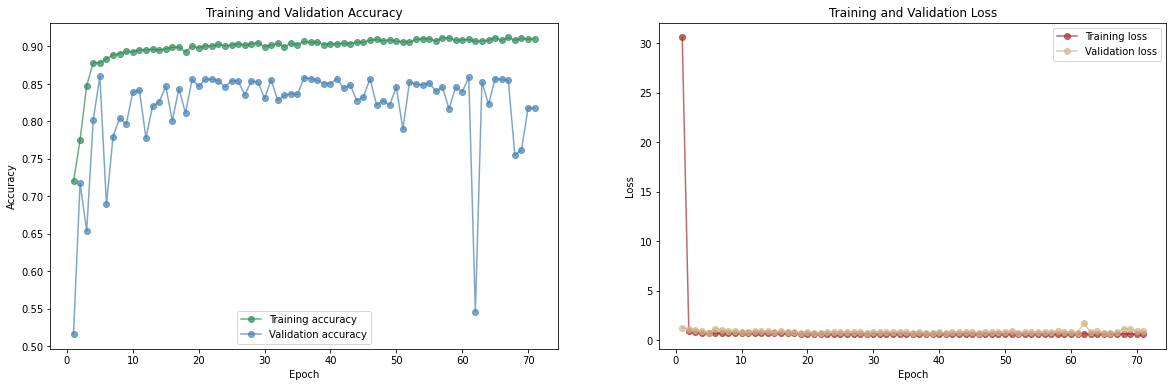

625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.9126 - loss: 0.6262
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8520 - loss: 0.7641
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 47ms/step - accuracy: 0.8520 - loss: 0.7496


Training Accuracy: 0.9129499793052673

Validation Accuracy: 0.856488823890686

In [25]:
plot(history)
train_acc = model.evaluate(x_train_int, y_train)[-1] 
val_acc = model.evaluate(x_val_int, y_val)[-1]
test_acc = model.evaluate(x_test_int, y_test)[-1]
print(f"Training Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")


save_model_results(val_results_path, model_name, val_acc)
save_model_results(test_results_path, model_name, test_acc)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**
In this new model, we have used an **L1-L2 regularization**. This has resulted in a model with very **stable** training and **almost no overfitting**. However, this over regularization has caused the model to **lose some performance** compared to the previous model. For the next model, we are going to test another type of recurrent layers, such as GRU.

</div>

## **Simple GRU**
### Bulding the model

In [11]:
model_name = "simple_GRU"

In [12]:
inputs = keras.Input(shape=(seqLength,))
x = layers.Embedding(maxFeatures, 200, mask_zero=True)(inputs)
x = layers.GRU(10, activation='relu',return_sequences=True)(x)
x = layers.GRU(10, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 166)       │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ embedding           │ (None, 166, 200)  │ 400,000 │ input_layer[0][0]    │
│ (Embedding)         │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ not_equal           │ (None, 166)       │       0 │ input_layer[0][0]    │
│ (NotEqual)          │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ gru (GRU)           │ (None, 166, 10)   │   6,360 │ embedding[0][0],     │
│                     │                   │         │ not_equal[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ gru_1 (GRU)         │ (None, 10)        │     660 │ gru[0][0],           │
│                     │                   │         │ not_equal[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense (Dense)       │ (None, 1)         │      11 │ gru_1[0][0]          │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 407,031 (1.55 MB)

 Trainable params: 407,031 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [13]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=30,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    x_train_int,
    y_train,
    epochs=500, 
    batch_size=batchSize, 
    validation_data=(x_val_int, y_val), 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5546 - loss: 1.0803 - val_accuracy: 0.7613 - val_loss: 0.5148
Epoch 2/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7840 - loss: 0.4929 - val_accuracy: 0.8085 - val_loss: 0.4836
Epoch 3/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8396 - loss: 0.4236 - val_accuracy: 0.8542 - val_loss: 0.4247
Epoch 4/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8842 - loss: 0.3337 - val_accuracy: 0.8754 - val_loss: 0.4347
Epoch 5/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.9024 - loss: 0.2945 - val_accuracy: 0.8532 - val_loss: 0.3916
Epoch 6/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8738 - loss: 0.3858 - val_accuracy: 0.8420 - val_loss: 0.4422
Epoch 7/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8866 - loss: 0.3146 - val_accuracy: 0.8598 - val_loss: 0.4227
Epoch 8/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9038 - loss: 0.2739 -

### Evaluation

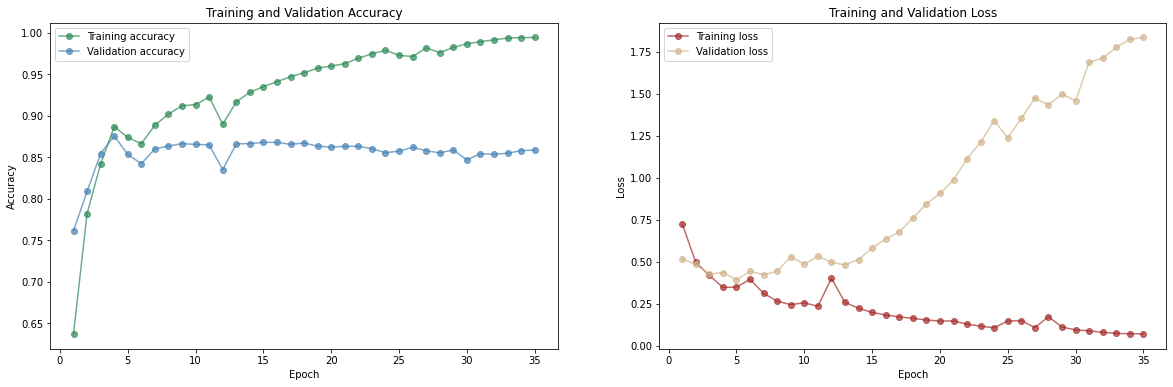

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8930 - loss: 0.3298
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8465 - loss: 0.4032
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8413 - loss: 0.4072


Training Accuracy: 0.8904500007629395

Validation Accuracy: 0.8531050682067871

In [14]:
plot(history)
train_acc = model.evaluate(x_train_int, y_train)[-1] 
val_acc = model.evaluate(x_val_int, y_val)[-1]
test_acc = model.evaluate(x_test_int, y_test)[-1]
print(f"Training Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")

save_model_results(val_results_path, model_name, val_acc)
save_model_results(test_results_path, model_name, test_acc)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**
Given the training results, we've obtained a model with a good accuracy, but we clearly see a large presence of **overfitting**. We will try in the next models to improve this performance and reduce the overfitting.

</div>

## **Medium complexity GRU**
### Building Model

In [15]:
model_name = "mid_complex_GRU"

In [16]:
inputs = keras.Input(shape=(seqLength,))
x = layers.Embedding(maxFeatures, 200, mask_zero=True)(inputs)
x = layers.GRU(10, activation='relu',return_sequences=True)(x)
x = layers.GRU(10, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 166)               │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 166, 200)          │     400,000 │ input_layer_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ not_equal_1 (NotEqual)        │ (None, 166)               │           0 │ input_layer_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gru_2 (GRU)                   │ (None, 166, 10)           │       6,360 │ embedding_1[0][0],             │
│                               │                           │             │ not_equal_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gru_3 (GRU)                   │ (None, 10)                │         660 │ gru_2[0][0], not_equal_1[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dense_1 (Dense)               │ (None, 32)                │         352 │ gru_3[0][0]                    │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │          33 │ dense_1[0][0]                  │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 407,405 (1.55 MB)

 Trainable params: 407,405 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [17]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=30,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    x_train_int,
    y_train,
    epochs=500, 
    batch_size=batchSize, 
    validation_data=(x_val_int, y_val), 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5444 - loss: 1.1371 - val_accuracy: 0.7178 - val_loss: 0.5908
Epoch 2/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7426 - loss: 0.5360 - val_accuracy: 0.7678 - val_loss: 0.5146
Epoch 3/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8037 - loss: 0.4446 - val_accuracy: 0.7969 - val_loss: 0.4744
Epoch 4/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7367 - loss: 0.5332 - val_accuracy: 0.4877 - val_loss: 1.4241
Epoch 5/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7318 - loss: 0.5395 - val_accuracy: 0.8386 - val_loss: 0.4287
Epoch 6/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8549 - loss: 0.3717 - val_accuracy: 0.8404 - val_loss: 0.4308
Epoch 7/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8757 - loss: 0.3241 - val_accuracy: 0.8653 - val_loss: 0.4102
Epoch 8/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8944 - loss: 0.2880 -

### Evaluation

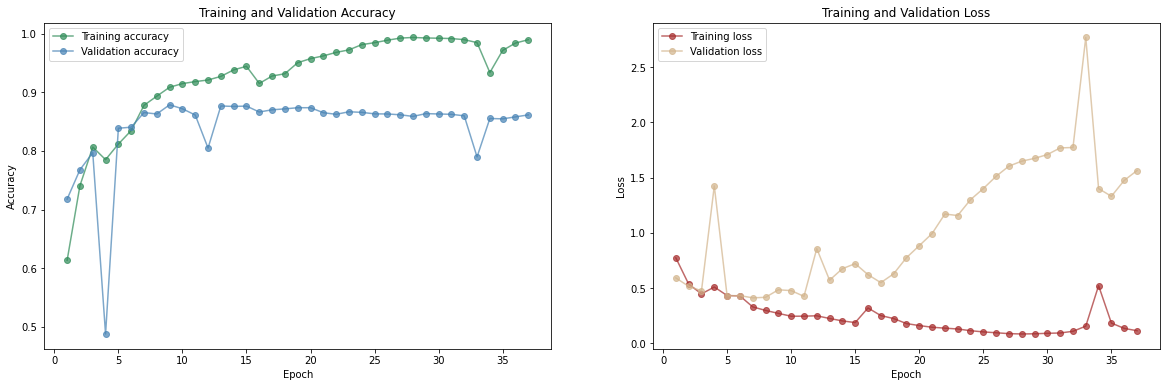

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8945 - loss: 0.2762
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8651 - loss: 0.4412
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8569 - loss: 0.4377


Training Accuracy: 0.8922500014305115

Validation Accuracy: 0.8644506335258484

In [18]:
plot(history)
train_acc = model.evaluate(x_train_int, y_train)[-1] 
val_acc = model.evaluate(x_val_int, y_val)[-1]
test_acc = model.evaluate(x_test_int, y_test)[-1]
print(f"Training Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")

save_model_results(val_results_path, model_name, val_acc)
save_model_results(test_results_path, model_name, test_acc)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**

To the previous model we have added a dense layer, trying to improve the results. In terms of accuracy, the **model yielded sightly better**, but we still have **significant overfitting**. So in the next model we will try to reduce this with the use of dropouts and regularization techniques.
</div>

## **Complex GRU - L2 - DropOut**
### Building the model

In [10]:
model_name = "complex_GRU_L2_dp"

In [11]:
inputs = keras.Input(shape=(seqLength,))
x = layers.Embedding(maxFeatures, 200, mask_zero=True)(inputs)
x = layers.GRU(128, return_sequences=True)(x)
x = layers.GRU(128)(x)
x = layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 166)               │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ embedding (Embedding)         │ (None, 166, 200)          │     400,000 │ input_layer[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ not_equal (NotEqual)          │ (None, 166)               │           0 │ input_layer[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gru (GRU)                     │ (None, 166, 128)          │     126,720 │ embedding[0][0],               │
│                               │                           │             │ not_equal[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gru_1 (GRU)                   │ (None, 128)               │      99,072 │ gru[0][0], not_equal[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dense (Dense)                 │ (None, 64)                │       8,256 │ gru_1[0][0]                    │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dense_1 (Dense)               │ (None, 64)                │       4,160 │ dense[0][0]                    │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dropout (Dropout)             │ (None, 64)                │           0 │ dense_1[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │          65 │ dropout[0][0]                  │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 638,273 (2.43 MB)

 Trainable params: 638,273 (2.43 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [12]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=20,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    x_train_int,
    y_train,
    epochs=500, 
    batch_size=batchSize, 
    validation_data=(x_val_int, y_val), 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/500
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 144ms/step - accuracy: 0.5735 - loss: 2.3138 - val_accuracy: 0.6924 - val_loss: 1.7371
Epoch 2/500
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.6878 - loss: 1.6531 - val_accuracy: 0.7492 - val_loss: 2.8504
Epoch 3/500
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 143ms/step - accuracy: 0.7376 - loss: 1.4634 - val_accuracy: 0.6873 - val_loss: 1.3124
Epoch 4/500
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.7106 - loss: 1.2588 - val_accuracy: 0.7734 - val_loss: 1.1858
Epoch 5/500
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.7646 - loss: 1.0928 - val_accuracy: 0.7611 - val_loss: 1.0021
Epoch 6/500
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 143ms/step - accuracy: 0.7238 - loss: 1.0139 - val_accuracy: 0.8174 - val_loss: 1.2512
Epoch 7/500
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 143ms/step - accuracy: 0.8476 - loss: 0.8409 - val_accuracy: 0.5410 - val_loss: 1.0165
Epoch 8/500
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 143ms/step - accuracy: 0.7351 -

### Evaluation

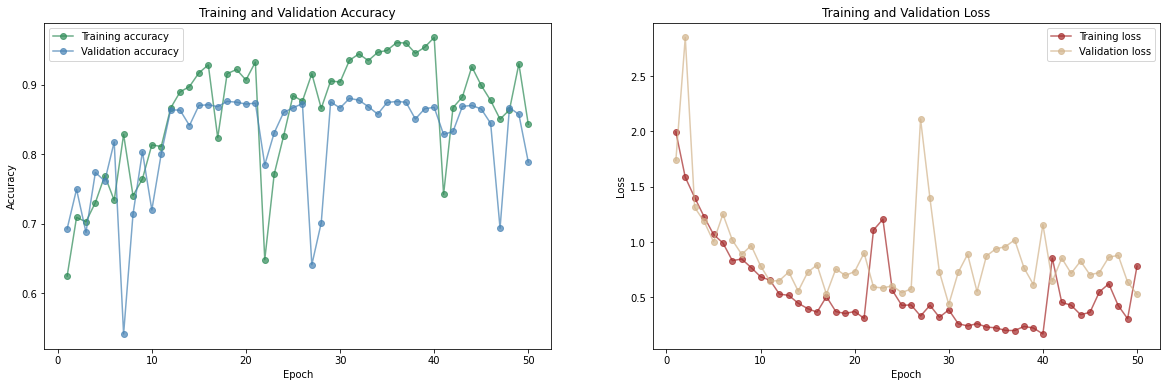

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.9273 - loss: 0.2752
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8705 - loss: 0.4274
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.8647 - loss: 0.4538


Training Accuracy: 0.9302499890327454

Validation Accuracy: 0.866042971611023

In [13]:
plot(history)
train_acc = model.evaluate(x_train_int, y_train)[-1] 
val_acc = model.evaluate(x_val_int, y_val)[-1]
test_acc = model.evaluate(x_test_int, y_test)[-1]
print(f"Training Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")

save_model_results(val_results_path, model_name, val_acc)
save_model_results(test_results_path, model_name, test_acc)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**

In this model, we have increased the **complexity** of both GRU and dense layers, and we have added a **dropout** and an **L2 regularization** to avoid overfitting. It can be seen on the plots above that the model **outperforms** the previous one in terms of accuracy, and also manages to **mitigate** the overfitting that the previous model had. Still, the training has some **instability**, so in the next model we will try to improve that aspect.

</div>

## **Complex GRU - L2 regularization + Bn**
### Building the model

In [14]:
model_name = "complex_GRU_L2_bn"

In [15]:
inputs = tf.keras.Input(shape=(seqLength,))
x = layers.Embedding(maxFeatures, 200, mask_zero=True)(inputs)
x = layers.BatchNormalization()(x)

x = layers.GRU(units=64, return_sequences=True,
                     kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))(x)
x = layers.GRU(units=128, return_sequences=True,
                     kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))(x)
x = layers.GRU(units=128, 
                     kernel_regularizer=l2(0.1), recurrent_regularizer=l2(0.1))(x)

x = layers.BatchNormalization()(x)
x = layers.Dense(64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs, name="sentiment_analysis")
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sentiment_analysis"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 166)               │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 166, 200)          │     400,000 │ input_layer_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ not_equal_1 (NotEqual)        │ (None, 166)               │           0 │ input_layer_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ batch_normalization           │ (None, 166, 200)          │         800 │ embedding_1[0][0],             │
│ (BatchNormalization)          │                           │             │ not_equal_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gru_2 (GRU)                   │ (None, 166, 64)           │      51,072 │ batch_normalization[0][0],     │
│                               │                           │             │ not_equal_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gru_3 (GRU)                   │ (None, 166, 128)          │      74,496 │ gru_2[0][0], not_equal_1[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gru_4 (GRU)                   │ (None, 128)               │      99,072 │ gru_3[0][0], not_equal_1[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ batch_normalization_1         │ (None, 128)               │         512 │ gru_4[0][0]                    │
│ (BatchNormalization)          │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dense_3 (Dense)               │ (None, 64)                │       8,256 │ batch_normalization_1[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dense_4 (Dense)               │ (None, 1)                 │          65 │ dense_3[0][0]                  │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 634,273 (2.42 MB)

 Trainable params: 633,617 (2.42 MB)

 Non-trainable params: 656 (2.56 KB)

### Training

In [16]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=20,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    x_train_int,
    y_train,
    epochs=100, 
    batch_size=batchSize, 
    validation_data=(x_val_int,y_val), 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 218ms/step - accuracy: 0.6407 - loss: 17.9217 - val_accuracy: 0.5150 - val_loss: 1.2616
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 217ms/step - accuracy: 0.8220 - loss: 0.7539 - val_accuracy: 0.5268 - val_loss: 0.8022
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 215ms/step - accuracy: 0.8721 - loss: 0.4147 - val_accuracy: 0.6162 - val_loss: 0.6870
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 218ms/step - accuracy: 0.8945 - loss: 0.3366 - val_accuracy: 0.8658 - val_loss: 0.3909
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 217ms/step - accuracy: 0.9082 - loss: 0.2892 - val_accuracy: 0.8652 - val_loss: 0.3802
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 216ms/step - accuracy: 0.9080 - loss: 0.2868 - val_accuracy: 0.8598 - val_loss: 0.4203
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 219ms/step - accuracy: 0.9231 - loss: 0.2577 - val_accuracy: 0.8666 - val_loss: 0.3726
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 220ms/step - accuracy: 0.9245 

### Evaluation

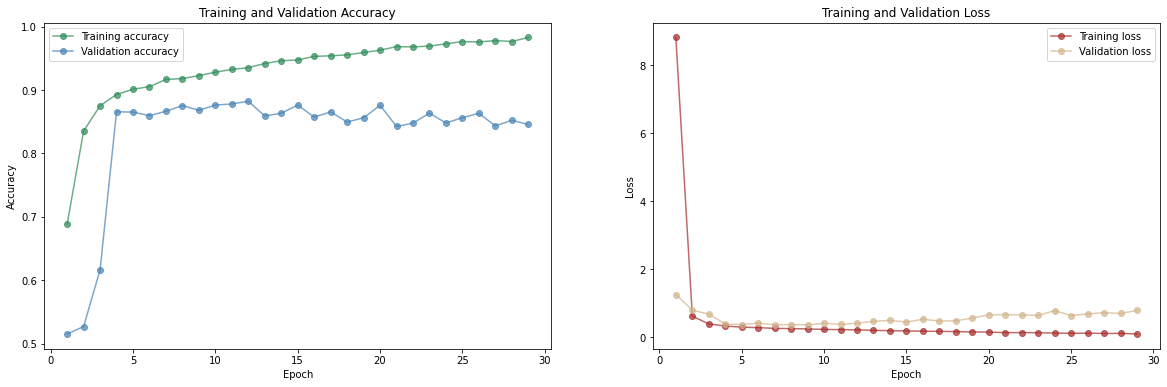

625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.9386 - loss: 0.2363
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.8667 - loss: 0.3746
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - accuracy: 0.8619 - loss: 0.3845


Training Accuracy: 0.9387000203132629

Validation Accuracy: 0.8680334687232971

In [17]:
plot(history)
train_acc = model.evaluate(x_train_int, y_train)[-1] 
val_acc = model.evaluate(x_val_int, y_val)[-1]
test_acc = model.evaluate(x_test_int, y_test)[-1]
print(f"Training Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")

save_model_results(val_results_path, model_name, val_acc)
save_model_results(test_results_path, model_name, test_acc)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**

In this model, we have removed the dropout from the architecture, but we have added a **BatchNormalization**, and a **recurrent L2 regularizer** in the recurrent layers. As a result, we have obtained a much more **stable** model during the whole training, but very similar results to the previous mode in accuracy terms. Since we are not able to surpass the **0.87** of accuracy, we are going to introduce more elements that can be helpful, such us **Bidirectional layers**, allowing the model to read the input text in both directions.
</div>

## **Complex Bidirectional LSTM - L2 Regularization + Bn**

### Building the model

In [24]:
model_name = "complex_bidirectional_LSTM_L2"

In [25]:
inputs = tf.keras.Input(shape=(seqLength,))
x = layers.Embedding(maxFeatures, 200, mask_zero=True)(inputs)
x = layers.BatchNormalization()(x)

x = layers.Bidirectional(layers.LSTM(units=64, return_sequences=True,
                     kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))(x)

x = layers.Bidirectional(layers.LSTM(units=128, return_sequences=True,
                     kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))(x)
x = layers.Bidirectional(layers.LSTM(units=128, 
                     kernel_regularizer=l2(0.1), recurrent_regularizer=l2(0.1)))(x)

x = layers.BatchNormalization()(x)
x = layers.Dense(64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs, name="sentiment_analysis")
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sentiment_analysis"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 166)               │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ embedding_3 (Embedding)       │ (None, 166, 200)          │     400,000 │ input_layer_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ not_equal_3 (NotEqual)        │ (None, 166)               │           0 │ input_layer_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ batch_normalization_2         │ (None, 166, 200)          │         800 │ embedding_3[0][0],             │
│ (BatchNormalization)          │                           │             │ not_equal_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ bidirectional_2               │ (None, 166, 128)          │     135,680 │ batch_normalization_2[0][0],   │
│ (Bidirectional)               │                           │             │ not_equal_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ bidirectional_3               │ (None, 166, 256)          │     263,168 │ bidirectional_2[0][0],         │
│ (Bidirectional)               │                           │             │ not_equal_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ bidirectional_4               │ (None, 256)               │     394,240 │ bidirectional_3[0][0],         │
│ (Bidirectional)               │                           │             │ not_equal_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ batch_normalization_3         │ (None, 256)               │       1,024 │ bidirectional_4[0][0]          │
│ (BatchNormalization)          │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dense_8 (Dense)               │ (None, 64)                │      16,448 │ batch_normalization_3[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dense_9 (Dense)               │ (None, 1)                 │          65 │ dense_8[0][0]                  │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 1,211,425 (4.62 MB)

 Trainable params: 1,210,513 (4.62 MB)

 Non-trainable params: 912 (3.56 KB)

### Training

In [26]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=20,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    x_train_int,
    y_train,
    epochs=100, 
    batch_size=batchSize, 
    validation_data=(x_val_int,y_val), 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 59s 357ms/step - accuracy: 0.7816 - loss: 44.4029 - val_accuracy: 0.5719 - val_loss: 1.2075
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 355ms/step - accuracy: 0.8828 - loss: 0.6001 - val_accuracy: 0.8463 - val_loss: 0.7210
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 356ms/step - accuracy: 0.8968 - loss: 0.3160 - val_accuracy: 0.6346 - val_loss: 0.6308
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 356ms/step - accuracy: 0.9104 - loss: 0.2669 - val_accuracy: 0.8859 - val_loss: 0.3448
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 355ms/step - accuracy: 0.9248 - loss: 0.2380 - val_accuracy: 0.8855 - val_loss: 0.3559
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 356ms/step - accuracy: 0.9373 - loss: 0.2095 - val_accuracy: 0.8592 - val_loss: 0.3900
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 57s 361ms/step - accuracy: 0.9450 - loss: 0.1925 - val_accuracy: 0.8695 - val_loss: 0.3578
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 57s 362ms/step - accuracy: 0.9500 

### Evaluation

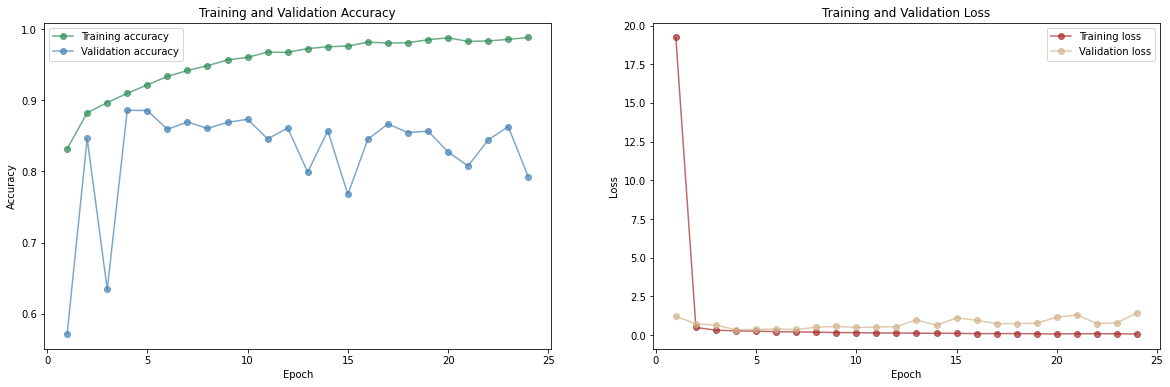

625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - accuracy: 0.9343 - loss: 0.2781
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.8832 - loss: 0.3454
782/782 ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/step - accuracy: 0.8750 - loss: 0.3525


Training Accuracy: 0.9351999759674072

Validation Accuracy: 0.8837579488754272

In [27]:
plot(history)
train_acc = model.evaluate(x_train_int, y_train)[-1] 
val_acc = model.evaluate(x_val_int, y_val)[-1]
test_acc = model.evaluate(x_test_int, y_test)[-1]
print(f"Training Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")

save_model_results(val_results_path, model_name, val_acc)
save_model_results(test_results_path, model_name, test_acc)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**
In this model we have tried to wrap several LSTM layers with **Bidirectional** layers, trying to improve the performance of the model. In addition, we have also applied techniques such as **L2 regularization** and **Batch Normalization** to avoid overfitting, methods that have proven to perform good previously. As a result, the training is quite stable, and the train and validation accuracy values are quite good. Numerous model architectures have been tested here, and the presented model is the one which **yielded better**, obtaining **the best validation accuracy so far**.

</div>

## **Maximum Sequence Size**

<div style="background-color: #ffffcc; padding: 10px;">


For the next step, we are going to train a model with the **longest possible sequence size** (the size of the **longest sentence**). We have decided to try this since many of the sentences may be **cut off** and some **important context could be lost**. However, it is noteworthy that increasing the sequence length could also lead to the previously explained **long memory issues**, even using architectures such us LSTMs or GRUs, leading to worse results due to the **deterioration of the context**.

</div>

In [88]:
x_train, y_train, seqLength = readData("data/amazon/train_small.txt")
x_test, y_test, tmp = readData("data/amazon/test_small.txt")

In [89]:
seqLength = max(list([len(sentence.split(' '))for sentence in x_train]))

In [90]:
x_train_int, y_train, x_val_int, y_val, x_test_int, y_test = transformData(x_train, y_train, x_test, y_test, 
maxFeatures, seqLength, val_size = val_size)

print(f"[bold purple]Training[/bold purple]   - X: {x_train_int.shape}\tY: {y_train.shape}")
print(f"[bold purple]Validation[/bold purple] - X: {x_val_int.shape}\tY: {y_val.shape}")
print(f"[bold purple]Test[/bold purple]       - X: {x_test_int.shape}\tY: {y_test.shape}")

Training   - X: (20000, 212)    Y: (20000,)

Validation - X: (5000, 212)     Y: (5000,)

Test       - X: (25000, 212)    Y: (25000,)

## **Long sequence Complex Bidirectional LSTM - L2 Regularization + Bn**
### Building the model

In [93]:
model_name = "large_sequence_complex_bidirectional_LSTM"

In [94]:
inputs = tf.keras.Input(shape=(seqLength,))
x = layers.Embedding(maxFeatures, 200, mask_zero=True)(inputs)
x = layers.BatchNormalization()(x)

x = layers.Bidirectional(layers.LSTM(units=64, return_sequences=True,
                     kernel_regularizer=l1_l2(0.001), recurrent_regularizer=l1_l2(0.001)))(x)

x = layers.Bidirectional(layers.LSTM(units=128, return_sequences=True,
                     kernel_regularizer=l1_l2(0.001), recurrent_regularizer=l1_l2(0.001)))(x)
x = layers.Bidirectional(layers.LSTM(units=128, 
                     kernel_regularizer=l1_l2(0.01), recurrent_regularizer=l1_l2(0.01)))(x)

x = layers.BatchNormalization()(x)
x = layers.Dense(64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs, name="sentiment_analysis")
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sentiment_analysis"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, 212)       │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ embedding_37        │ (None, 212, 200)  │ 400,000 │ input_layer_38[0][0] │
│ (Embedding)         │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ not_equal_20        │ (None, 212)       │       0 │ input_layer_38[0][0] │
│ (NotEqual)          │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 212, 200)  │     800 │ embedding_37[0][0],  │
│ (BatchNormalizatio… │                   │         │ not_equal_20[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ bidirectional_40    │ (None, 212, 128)  │ 135,680 │ batch_normalization… │
│ (Bidirectional)     │                   │         │ not_equal_20[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ bidirectional_41    │ (None, 212, 256)  │ 263,168 │ bidirectional_40[0]… │
│ (Bidirectional)     │                   │         │ not_equal_20[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ bidirectional_42    │ (None, 256)       │ 394,240 │ bidirectional_41[0]… │
│ (Bidirectional)     │                   │         │ not_equal_20[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 256)       │   1,024 │ bidirectional_42[0]… │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_54 (Dense)    │ (None, 64)        │  16,448 │ batch_normalization… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_55 (Dense)    │ (None, 1)         │      65 │ dense_54[0][0]       │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 1,211,425 (4.62 MB)

 Trainable params: 1,210,513 (4.62 MB)

 Non-trainable params: 912 (3.56 KB)

### Training

In [95]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=20,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    x_train_int,
    y_train,
    epochs=100, 
    batch_size=batchSize, 
    validation_data=(x_val_int,y_val), 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 472ms/step - accuracy: 0.7724 - loss: 86.0011 - val_accuracy: 0.8018 - val_loss: 2.3346
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 469ms/step - accuracy: 0.8841 - loss: 1.5301 - val_accuracy: 0.5367 - val_loss: 1.3577
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 473ms/step - accuracy: 0.8972 - loss: 0.9135 - val_accuracy: 0.8482 - val_loss: 1.0984
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 470ms/step - accuracy: 0.9113 - loss: 0.8183 - val_accuracy: 0.8564 - val_loss: 0.9280
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 473ms/step - accuracy: 0.9192 - loss: 0.7847 - val_accuracy: 0.7186 - val_loss: 1.2987
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 471ms/step - accuracy: 0.9218 - loss: 0.7718 - val_accuracy: 0.8105 - val_loss: 1.0814
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 473ms/step - accuracy: 0.9317 - loss: 0.7419 - val_accuracy: 0.6926 - val_loss: 1.5280
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 73s 467ms/step - accuracy: 0.9403 

### Evaluation

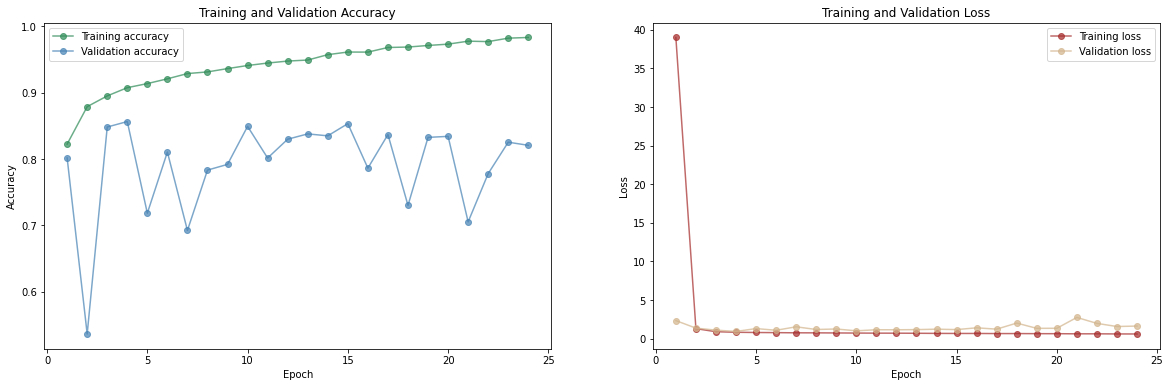

625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.9114 - loss: 0.8569
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.8620 - loss: 0.9256
782/782 ━━━━━━━━━━━━━━━━━━━━ 61s 78ms/step - accuracy: 0.8595 - loss: 0.9271


Training Accuracy: 0.9101999998092651

Validation Accuracy: 0.8584793210029602

In [96]:
plot(history)
train_acc = model.evaluate(x_train_int, y_train)[-1] 
val_acc = model.evaluate(x_val_int, y_val)[-1]
test_acc = model.evaluate(x_test_int, y_test)[-1]
print(f"Training Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")

save_model_results(val_results_path, model_name, val_acc)
save_model_results(test_results_path, model_name, test_acc)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**
As can be seen, the results **did not improve** on the previous ones, so it seems that having more context does not help the model to improve in this case. This could be related with the previous explanation, where it could be that the words that some **important words** **lose their influence** due to **excessive long sequences**. 

For this reason, and trying to solve this issue, we will place a **Multi-Head Attention layer**, thus allowing the model to create **contextual embeddings** focusing the attention on the critical words.
</div>

## **Using Multi-Head Attention**
### Building the model

In [97]:
model_name = "LSTM_Attention"

In [98]:
l2_reg = 0.001  # Regularization factor

# Model definition
inputs = layers.Input(shape=(seqLength,))

# Embedding layer with mask generation
embedding_layer = layers.Embedding(maxFeatures, 256)
x = embedding_layer(inputs)
mask = embedding_layer.compute_mask(inputs)
mask_att = embedding_layer.compute_mask(inputs)

if mask_att is not None:
    mask_att = tf.cast(mask_att, dtype='bool')
    mask_att = tf.tile(tf.expand_dims(mask_att, axis=1), [1, tf.shape(x)[1], 1])  # Adjusting the mask to the right shape


# Multi-head attention layer adding the mask for padding
multi_head_attention = layers.MultiHeadAttention(num_heads=10, key_dim=256, value_dim=256)
attention_output = multi_head_attention(x, x, attention_mask=mask_att)
attention_output = layers.BatchNormalization()(attention_output)

mask = embedding_layer.compute_mask(inputs)



# LSTM layers
x = layers.Bidirectional(layers.LSTM(units=64, return_sequences=True,
                kernel_regularizer=l2(l2_reg),
                recurrent_regularizer=l2(l2_reg)))(attention_output, mask=mask)

x = layers.Bidirectional(layers.LSTM(units=128, return_sequences=True,
                kernel_regularizer=l2(0.001),
                recurrent_regularizer=l2(0.001)))(x, mask=mask)

x = layers.Bidirectional(layers.LSTM(units=128, return_sequences=False,
                kernel_regularizer=l2(0.01),
                recurrent_regularizer=l2(0.01)))(x, mask=mask)

# Output layers
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

# Model setup
model = Model(inputs=inputs, outputs=outputs, name="advanced_sentiment_analysis_pre_attention")
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "advanced_sentiment_analysis_pre_attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_39      │ (None, 212)       │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ embedding_38        │ (None, 212, 256)  │ 512,000 │ input_layer_39[0][0] │
│ (Embedding)         │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ multi_head_attenti… │ (None, 212, 256)  │ 2,629,… │ embedding_38[0][0],  │
│ (MultiHeadAttentio… │                   │         │ embedding_38[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 212, 256)  │   1,024 │ multi_head_attentio… │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ bidirectional_43    │ (None, 212, 128)  │ 164,352 │ batch_normalization… │
│ (Bidirectional)     │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ bidirectional_44    │ (None, 212, 256)  │ 263,168 │ bidirectional_43[0]… │
│ (Bidirectional)     │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ bidirectional_45    │ (None, 256)       │ 394,240 │ bidirectional_44[0]… │
│ (Bidirectional)     │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 256)       │   1,024 │ bidirectional_45[0]… │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_56 (Dense)    │ (None, 64)        │  16,448 │ batch_normalization… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_57 (Dense)    │ (None, 1)         │      65 │ dense_56[0][0]       │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 3,981,697 (15.19 MB)

 Trainable params: 3,980,673 (15.19 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [99]:
# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10,
    restore_best_weights=True
)

# Train the model with the EarlyStopping callback
history = model.fit(
    x_train_int,
    y_train,
    epochs=100, 
    batch_size=batchSize, 
    validation_data=(x_val_int,y_val), 
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the callbacks list
)

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.6825 - loss: 6.0051 - val_accuracy: 0.5635 - val_loss: 1.3882
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.8860 - loss: 0.8438 - val_accuracy: 0.7395 - val_loss: 0.7515
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.8935 - loss: 0.4804 - val_accuracy: 0.8752 - val_loss: 0.5502
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.8985 - loss: 0.3610 - val_accuracy: 0.8426 - val_loss: 0.4321
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.9130 - loss: 0.2888 - val_accuracy: 0.8650 - val_loss: 0.3845
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.9166 - loss: 0.2527 - val_accuracy: 0.8670 - val_loss: 0.3636
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.9213 - loss: 0.2297 - val_accuracy: 0.8529 - val_loss: 0.4111
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 105ms/step - accuracy: 0.9210 -

### Evaluation

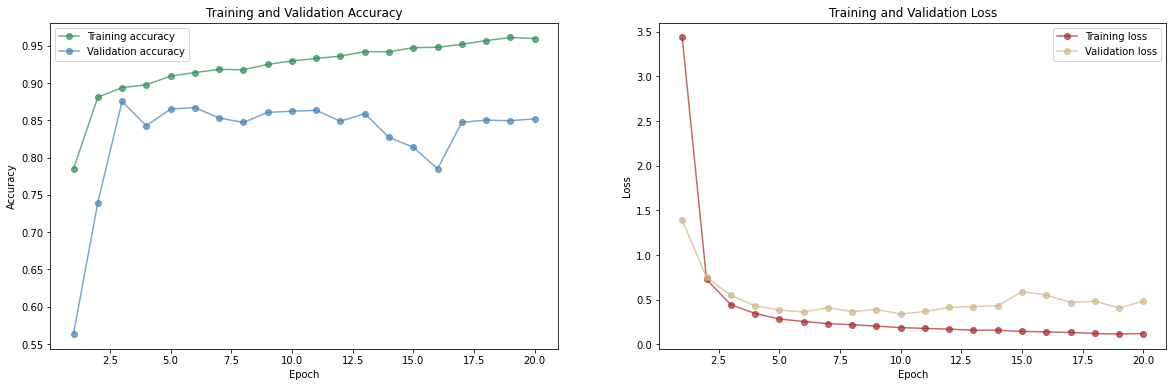

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9423 - loss: 0.1917
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8710 - loss: 0.3300
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.8651 - loss: 0.3294


Training Accuracy: 0.9433000087738037

Validation Accuracy: 0.8666401505470276

In [100]:
plot(history)
train_acc = model.evaluate(x_train_int, y_train)[-1] 
val_acc = model.evaluate(x_val_int, y_val)[-1]
test_acc = model.evaluate(x_test_int, y_test)[-1]
print(f"Training Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")


save_model_results(val_results_path, model_name, val_acc)
save_model_results(test_results_path, model_name, test_acc)

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**
In this model, we have utilized a **Multi-Head Attention layer**, aiming to keep the model **focused** on important words and thereby create better **contextual** embeddings. However, from the results, it is evident that **no improvement** has been achieved. Although the results obtained are **slightly** better than those from the previous LSTM model, which used the same sequence size, it has **not surpassed** the performance of other models tested previously, yielding very **similar results**.
</div>

## **Results summary and discussion**
### Obtaining the results
All the results have been saved previously for each model for both datasets. In this section, we collect all those results and create several dictionaries to use the utility function plot_results_grouped. This allows a clear comparison between the different models.

In [156]:
val_results_path = os.path.join('.','val_results.csv')
test_results_path = os.path.join('.','test_results.csv')

In [159]:
val_results = csv_to_dict(val_results_path)
test_results = csv_to_dict(test_results_path)

In [170]:
test_results_by_model = filter_models_by_keywords(test_results, ['Attention','large_sequence', 'bidirectional', 'GRU', 'LSTM', 'SimpleRNN'])
val_results_by_model = filter_models_by_keywords(val_results, ['Attention','large_sequence', 'bidirectional', 'GRU', 'LSTM', 'SimpleRNN'])

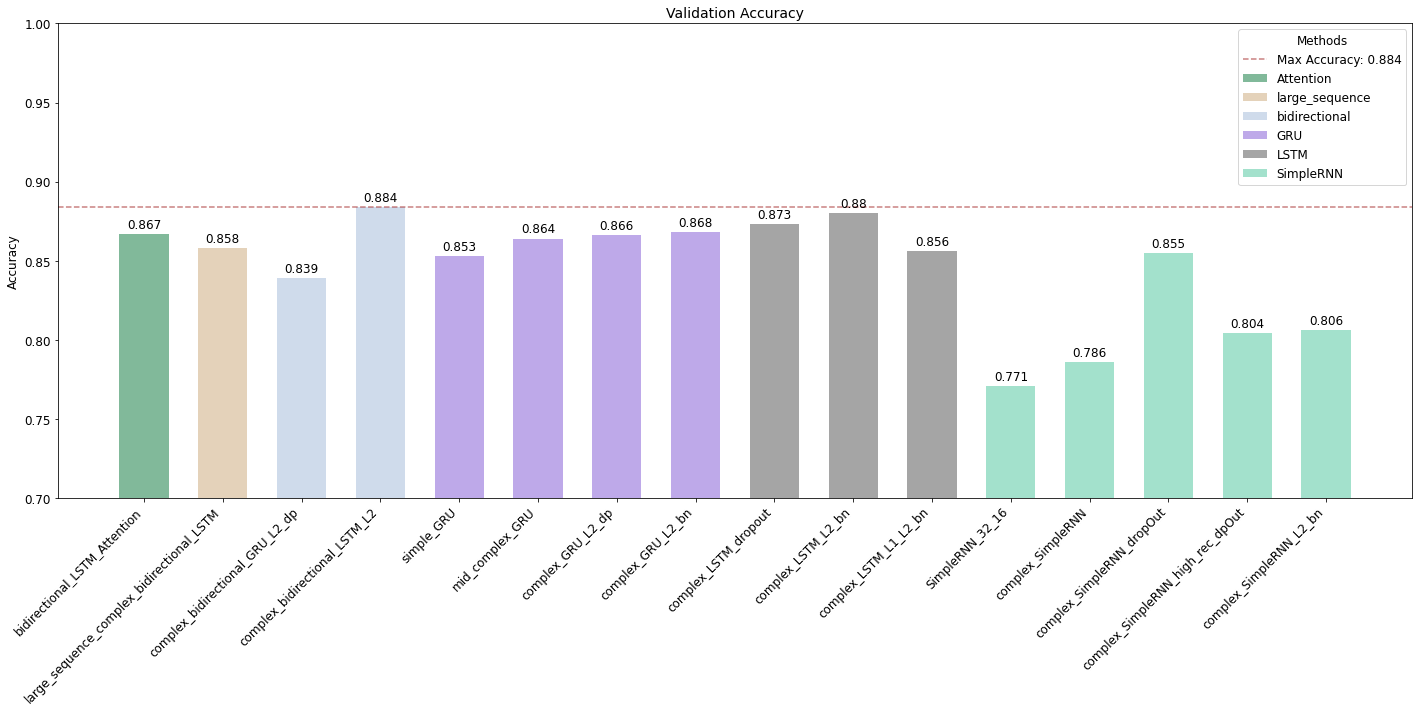

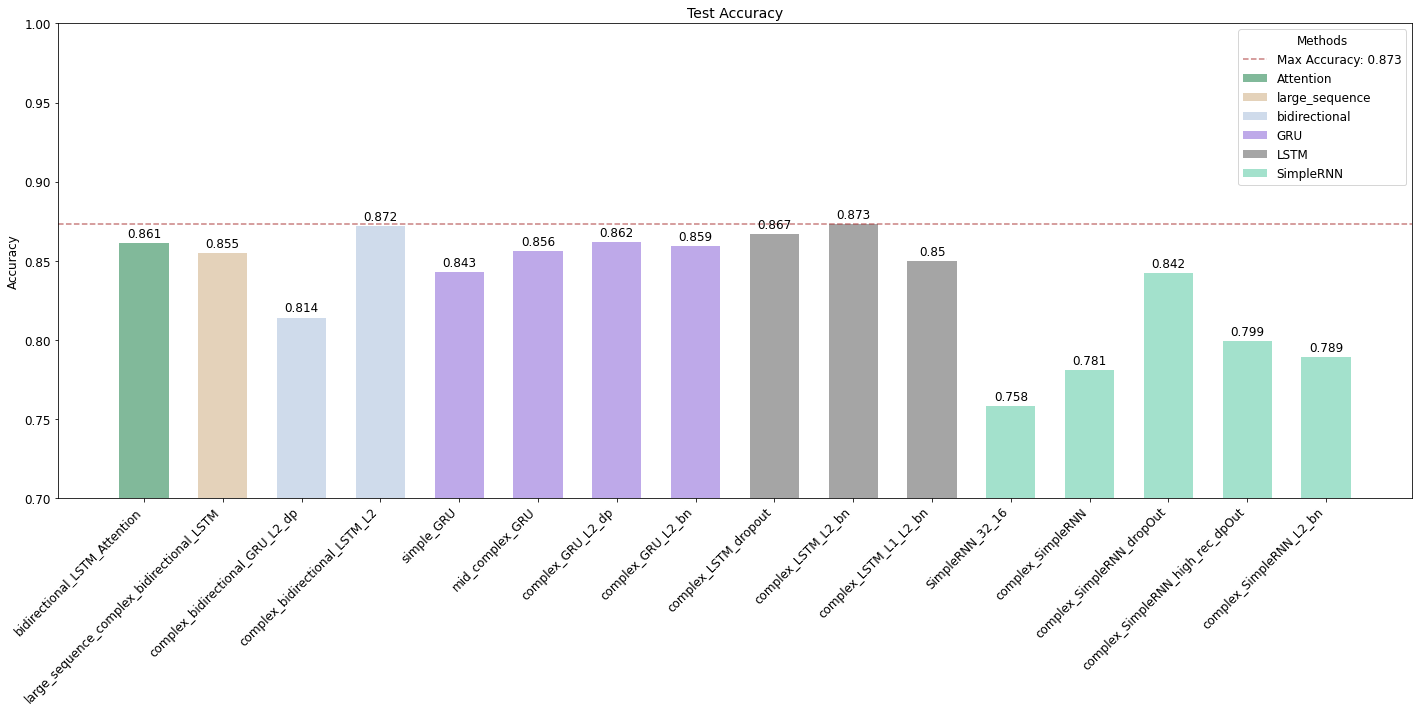

In [173]:
plot_results_grouped(val_results_by_model, title='Validation Accuracy', y_lim=(0.7, 1))
plot_results_grouped(test_results_by_model, title='Test Accuracy', y_lim=(0.7, 1))

<div style="background-color: #e6ffe6; padding: 10px;">

## **Summary of Experimental Insights**

Throughout our experimentation with RNN, as well as more advanced architectures like LSTMs and GRUs, we have explored various configurations looking to obtain high accuracy on sentiment classification. Initial trials with **SimpleRNN** models showed noticeable **overfitting** and learning limitation, probably as a result of **some limitations** with **large sequences**, leading to a shift towards **more complex** architectures and **regularization techniques**. 

Regularization strategies like **dropout**, **recurrent dropout**, and **L2 regularization** were tested, with **L2 combined** with **batch normalization** proving **particularly effective** in **stabilizing** training without compromising the learning ability excessively. 

The introduction of **LSTM** models marked a **significant improvement** in performance, although overfitting remained a challenge addressed by increasing regularization strength and model complexity. The exploration of **GRU** models and subsequent introduction of **bidirectional** layers and **multi-head attention** aimed to leverage **additional contextual information** and focus on critical aspects of the data, although these innovations did **not always result in superior performance**.

### **Important Insights**

- **Regularization Techniques**: The use of dropout was generally less effective, particularly at **higher** probabilities. **Recurrent dropout** and a combination of **L2 regularization** with **batch normalization** provided the best balance between preventing overfitting and maintaining training stability.

- **Model Complexity**: Increasing complexity initially improved performance, but **very complex** configurations, especially in LSTM setups, did not yield additional benefits and sometimes worsened performance.

- **Advanced Architectures**: Switching to LSTMs improved accuracy, but overfitting persisted until further regularization. GRUs offered mixed results but have been outperformed by LSTMs. On the other hand, **bidirectional** layers and **multi-head** attention, despite obtaining quite good results, did not significantly surpass the unidirectional configurations.

- **Loss of Information in Long Sequences**: Standard RNNs struggle to maintain information from earlier states in long sequences, often losing critical early data as the sequence progresses. This motivates the use of more sophisticated structures like LSTMs and GRUs, which are designed to manage long-term information more effectively, and as expected yielded better results.

- **Attention Mechanisms**: Attempts to improve model performance through the introduction of multi-head attention mechanisms did not yield the expected improvements.

- **Test Results**: The model that achieved the best results in testing is the complex **LSTM with L2 regularization and batch normalization**, achieving a test accuracy of **0.873**. Several models, including the **bidirectional LSTM**, approached these results, but despite extensive experimentation, this accuracy could not be improved further. 

</div>